In [1]:
import numpy as np 
import pandas as pd 

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from glob import glob

from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *


In [2]:
lung_img_dir = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
mask_img_dir = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/'


lung_img_dir_glob = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/*.png'
mask_img_dir_glob = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/*.png'

lung_img = glob(lung_img_dir_glob)
mask_img = glob(mask_img_dir_glob)

In [3]:
len(lung_img), len(mask_img)
# We have 800 lung images but only 704 masks 

(800, 704)

In [4]:
# Create 1-1 relation
lungs_filenames = [name.split('/')[-1].split('.png')[0] for name in lung_img]
import re
import cv2
lung_paths = []
mask_paths = []
for lungs_filename in lungs_filenames:
    for mask_filename in mask_img:
        mask_match = re.search(lungs_filename, mask_filename)
        if mask_match:
            lung_paths.append(os.path.join(lung_img_dir,f"{lungs_filename}.png"))
            mask_paths.append(mask_filename)

In [5]:
assert len(mask_paths) == len(lung_paths)
print(f'Total number of samples {len(lung_paths)}')

Total number of samples 704


### Load images

In [6]:
X = np.zeros((len(lung_paths),256,256))
y = np.zeros((len(lung_paths),256,256))

# Convert images to gray, resize and normalize for NN
def transform_img(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    reshape_img = cv2.resize(img_gray,img_shape)
    return reshape_img/255.0

In [7]:
# Loading images and masks
img_shape = (256,256)
for i, lung_path in tqdm(enumerate(lung_paths)):
    lung_img = cv2.imread(lung_path)
    X[i] = transform_img(lung_img)
for i , mask_path in tqdm(enumerate(mask_paths)):
    mask_img = cv2.imread(mask_path)
    y[i] = transform_img(mask_img)

704it [02:23,  4.92it/s]
704it [01:12,  9.76it/s]


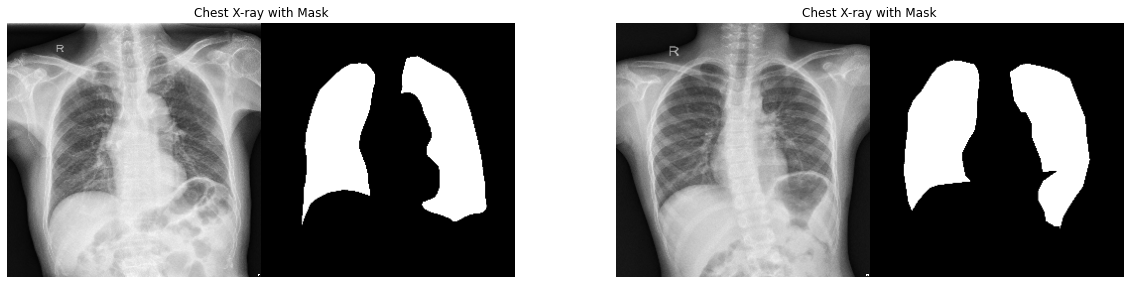

In [8]:
def plotMask(X,y):
    i,j = np.random.randint(0,len(X),2)
    plt.figure(figsize=(20,20))
    
    plt.subplot(121)
    plt.axis('off')
    plt.title('Chest X-ray with Mask')
    plt.imshow(np.hstack((X[i],y[i])), cmap = 'gray')
    plt.subplot(122)
    plt.axis('off')
    plt.title('Chest X-ray with Mask')
    plt.imshow(np.hstack((X[j],y[j])), cmap = 'gray')
    plt.savefig('sample.jpeg')
    plt.show()
    
plotMask(X,y)

### U-net model

In [9]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy",
                  metrics=['binary_accuracy'])
model.summary()

2022-05-03 21:59:51.650003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 21:59:51.753357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 21:59:51.754576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 21:59:51.756438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Callbacks

In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="best_model.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduce = ReduceLROnPlateau(monitor='val_loss',
                                   patience=5, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3) 
callbacks = [checkpoint,reduce, early]


### Train Model

In [12]:
EPOCHS = 10
batch_size = 32
validation_spit = 0.2
history = model.fit(x = X, 
                    y = y, 
                    validation_split = validation_spit, 
                    epochs = EPOCHS, 
                    batch_size = batch_size,
                   callbacks = callbacks )

2022-05-03 21:59:59.413646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-03 22:00:02.134039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 22s 543ms/step - loss: 0.6043 - binary_accuracy: 0.7457 - val_loss: 0.5571 - val_binary_accuracy: 0.7473

Epoch 00001: val_loss improved from inf to 0.55713, saving model to best_model.h5
Epoch 2/10
18/18 [==============================] - 5s 276ms/step - loss: 0.5279 - binary_accuracy: 0.7458 - val_loss: 0.4557 - val_binary_accuracy: 0.7473

Epoch 00002: val_loss improved from 0.55713 to 0.45574, saving model to best_model.h5
Epoch 3/10
18/18 [==============================] - 5s 276ms/step - loss: 0.5027 - binary_accuracy: 0.7458 - val_loss: 0.4620 - val_binary_accuracy: 0.7473

Epoch 00003: val_loss did not improve from 0.45574
Epoch 4/10
18/18 [==============================] - 5s 275ms/step - loss: 0.4187 - binary_accuracy: 0.7458 - val_loss: 0.3640 - val_binary_accuracy: 0.7473

Epoch 00004: val_loss improved from 0.45574 to 0.36398, saving model to best_model.h5
Epoch 5/10
18/18 [==============================] - 5s 275ms/step - loss: 0.3

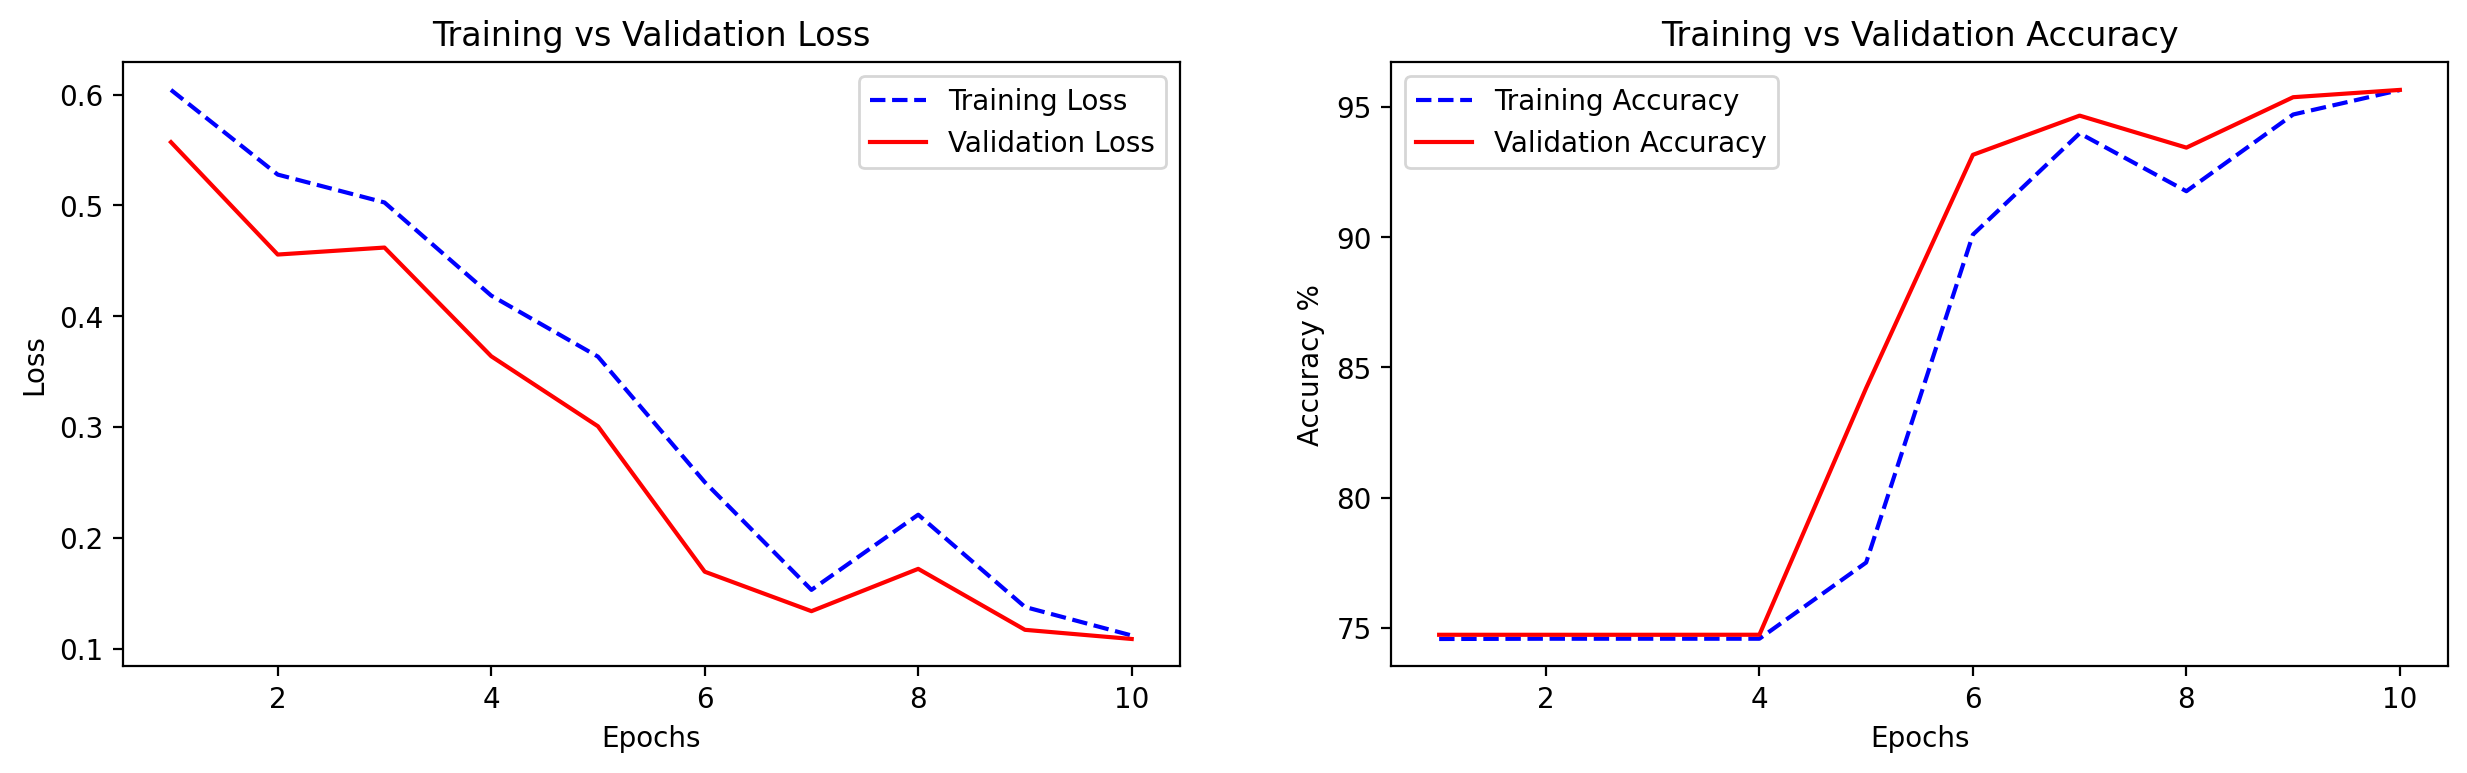

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4),dpi=200)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

ax[0].plot(epoch_count, training_loss, 'b--')
ax[0].plot(epoch_count, validation_loss, 'r-')
ax[0].legend(['Training Loss', 'Validation Loss'])
ax[0].set_title('Training vs Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')

ax[1].plot(epoch_count, 100* np.array(training_accuracy), 'b--')
ax[1].plot(epoch_count, 100 *np.array(validation_accuracy), 'r-')
ax[1].legend(['Training Accuracy', 'Validation Accuracy'])
ax[1].set_title('Training vs Validation Accuracy')
ax[1].set_ylabel('Accuracy %')
ax[1].set_xlabel('Epochs')
plt.savefig('model.jpeg')

### Load test data

In [14]:
test_dir = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/*'
test_img = glob(test_dir)

In [15]:
def add_mask(img,mask):
    _ , mask = cv2.threshold(mask ,0.3,1,cv2.THRESH_BINARY)
    merged = cv2.addWeighted(img, 0.7, mask.astype(np.float64), 0.3, 0)
    return merged
    

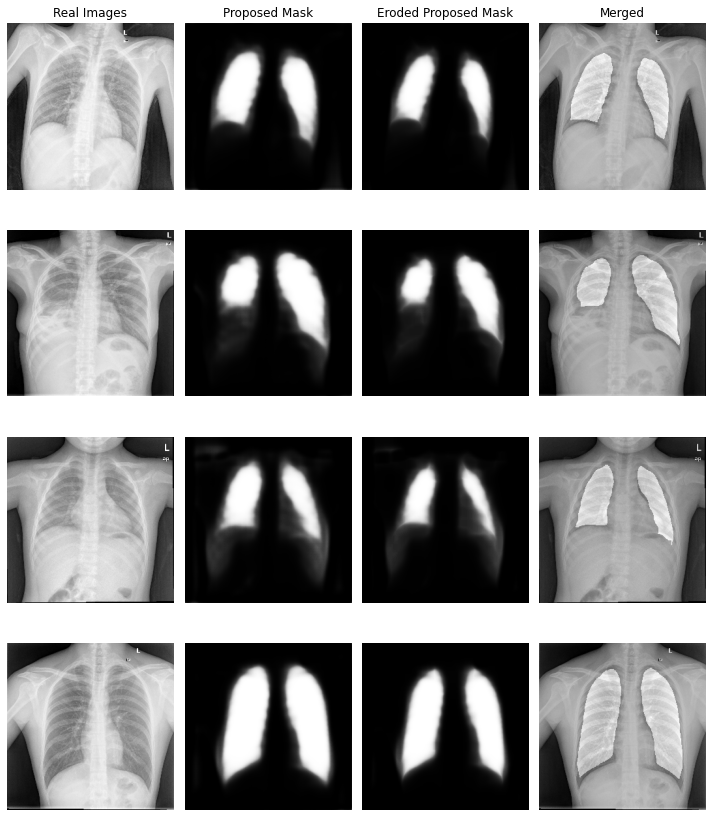

In [16]:
def plot_test(test_img,
              kernel =np.ones((5, 5),
                              np.uint8),
              save = False):
    size = 4
    test_size = len(test_img)
    test_sample = np.array(test_img)[np.random.randint(0, test_size, size).astype(int)]
    fig, axs = plt.subplots(nrows=size, ncols=4, figsize=(10, 12))
    cols = ['Real Images', 'Proposed Mask', 'Eroded Proposed Mask', 'Merged']
    
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
        
        
    axs = axs.ravel()
    
    for i in range(16):

        if i %4 == 0:
            
            img = cv2.imread(test_sample[i//4])
            img = transform_img(img)
            axs[i].imshow(img, cmap = 'gray')

        elif i %4 == 1:
            mask = model.predict(np.array([img]))
            axs[i].imshow(mask[0], cmap = 'gray')
        
        elif i %4 == 2:         
             erode_img = cv2.erode(mask[0], kernel, iterations=2) 
             axs[i].imshow(erode_img, cmap = 'gray')
        else:
             merged = add_mask(img, erode_img)
             axs[i].imshow(merged, cmap = 'gray')
        axs[i].axis('off')

    if save:
        plt.savefig('predicted_mask.jpeg')
    fig.tight_layout()
    plt.show()

kernel =  kernel =np.ones((5, 5), np.uint8)
plot_test(test_img, save =True)